In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from gplearn import genetic
from gplearn.functions import make_function
from gplearn.genetic import SymbolicTransformer, SymbolicRegressor
from gplearn.fitness import make_fitness
from sklearn.linear_model import LinearRegression

In [40]:
etf_data = pd.read_csv('5500_dataset2.csv')
etf_data['Date'] = etf_data['Year'].astype(str) + '-' + etf_data['Month'].astype(str)
etf_data['Date'] = pd.to_datetime(etf_data['Date'], format='%Y-%m')
etf_data.set_index('Date', inplace=True)
etf_data.drop(['Year', 'Month'], axis=1, inplace=True)
etf_data = etf_data.resample('M').last()
tickers = ['XLB', 'XLC', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY']
macro_vars = [col for col in etf_data.columns if col not in tickers]
etf_data_long = etf_data.reset_index().melt(id_vars=['Date'], value_vars=tickers,
                                            var_name='Tickers', value_name='Price')
macro_data = etf_data[macro_vars]
df = etf_data_long.merge(macro_data, left_on='Date', right_index=True)
df.set_index(['Tickers', 'Date'], inplace=True)
df.sort_index(level='Tickers', inplace=True)
df['Return'] = df['Price'].pct_change()
df = df.dropna()
df

Price  BusinessApplications  ConstructionSpending  \
Tickers Date                                                                
XLB     2004-12-31   19.24945                193328               1037480   
        2005-01-31   18.66025                201725               1046082   
        2005-02-28   20.13002                204234               1066848   
        2005-03-31   19.59500                201630               1071745   
        2005-04-30   18.19814                204096               1081012   
...                       ...                   ...                   ...   
XLY     2024-04-30  174.88220                430762               2163179   
        2024-05-31  175.23070                423211               2168211   
        2024-06-30  182.02440                430692               2168990   
        2024-07-31  187.10390                421534               2162683   
        2024-08-31  186.73470                431928               2162683   

                    DurableGoodsNewOrders  InternationalTrade_Exports  \
Tickers Date                                                            
XLB     2004-12-31                 193578                      102781   
        2005-01-31                 194875                      103206   
        2005-02-28                 196475                      104010   
        2005-03-31                 186608                      105098   
        2005-04-30                 194847                      107268   
...                                   ...                         ...   
XLY     2024-04-30                 282737                      262314   
        2024-05-31                 282987                      260790   
        2024-06-30                 263541                      265266   
        2024-07-31                 289587                      266603   
        2024-08-31                 289720                      266603   

                    InternationalTrade_Imports  ManuInventories  \
Tickers Date                                                      
XLB     2004-12-31                      157699           441222   
        2005-01-31                      159395           446240   
        2005-02-28                      162104           451361   
        2005-03-31                      158231           455394   
        2005-04-30                      164580           456990   
...                                        ...              ...   
XLY     2024-04-30                      337217           858304   
        2024-05-31                      336096           859416   
        2024-06-30                      338282           858851   
        2024-07-31                      345394           859422   
        2024-08-31                      345394           859422   

                    ManuNewOrders  NewHomesForSale  NewHomesSold  ...  \
Tickers Date                                                      ...   
XLB     2004-12-31         373419              422          1242  ...   
        2005-01-31         378937              441          1203  ...   
        2005-02-28         381880              446          1319  ...   
        2005-03-31         374642              445          1328  ...   
        2005-04-30         385450              445          1260  ...   
...                           ...              ...           ...  ...   
XLY     2024-04-30         586114              464           736  ...   
        2024-05-31         583300              468           672  ...   
        2024-06-30         563972              468           681  ...   
        2024-07-31         592140              459           751  ...   
        2024-08-31         592140              467           716  ...   

                        CPI  Housing Starts  Monetary Base       M2  \
Tickers Date                                                          
XLB     2004-12-31  191.700            1782          770.5   6399.8   
        2005-01-31  191.700          

In [5]:
features = [col for col in df.columns if col not in ['Price', 'Return']]
X = df[features]
Y = df['Return']

for feature in features:
    if df[feature].dtype == 'object':
        df[feature] = df[feature].str.replace(',', '').astype(float)
        
# Prepare the output dataframe to store rolling exposures
rolling_exposure = pd.DataFrame(index=df.index, columns=features)

# Rolling window length (36 months)
window_length = 36

# Iterate through each ticker group to calculate rolling exposures
for ticker, group in df.groupby(level='Tickers'):
    for end_idx in range(window_length, len(group)):
        window_data = group.iloc[end_idx - window_length:end_idx]
        
        X_window = window_data[features]
        Y_window = window_data['Return']
        
        if len(X_window) == window_length:
            # Fit linear regression model
            model = LinearRegression().fit(X_window, Y_window)
            # Store the coefficients as rolling exposures
            rolling_exposure.loc[window_data.index[-1], features] = model.coef_

# Drop NaN values
rolling_exposure.dropna(inplace=True)


In [6]:
Rank_IC = rolling_exposure['Unemp_Rate'].unstack('Tickers').corrwith(df.unstack('Tickers')['Return'], axis =1,  method='spearman').dropna(how='all')

In [7]:
returns = df.unstack('Tickers')['Return']
exposures = rolling_exposure.unstack('Tickers')
date_list = exposures.index

In [8]:
exposures['CPI'].corrwith(returns, axis=1, method='spearman').dropna(how='all')

Date
2007-11-30   -0.450000
2007-12-31   -0.183333
2008-01-31    0.516667
2008-02-29    0.650000
2008-03-31    0.466667
                ...   
2024-04-30    0.309091
2024-05-31    0.536364
2024-06-30   -0.054545
2024-07-31   -0.063636
2007-10-31   -0.571429
Length: 202, dtype: float64

In [9]:
def exposure_return_IC(exposures, returns, index_item, name=''):
    result = exposures.corrwith(returns, axis=1, method='spearman').dropna(how='all')
    t_stat, _ = stats.ttest_1samp(result, 0)
    
    report = {'name': name,
    'IC mean':round(result.mean(),4),
    'IC std':round(result.std(),4),
    'IR':round(result.mean()/result.std(),4),
    'IC>0':round(len(result[result>0].dropna())/len(result),4),
    'ABS_IC>2%':round(len(result[abs(result) > 0.02].dropna())/len(result),4),
    't_stat':round(t_stat,4),
    }

    report = pd.DataFrame([report])
    
    return result,report
                                                                        
                                                                           

In [10]:
ic_summary = pd.DataFrame()
ic_df=pd.DataFrame(index=date_list)
for feature in features:
    ic, ic_summary_temp = exposure_return_IC(exposures[feature],returns, feature,feature)
    ic_df = pd.concat([ic_df, ic.to_frame(feature)], axis=1)
    ic_summary = pd.concat([ic_summary,ic_summary_temp.set_index('name')],axis = 0)
ic_df = ic_df.sort_index()

In [11]:
ic_summary

,IC mean,IC std,IR,IC>0,ABS_IC>2%,t_stat
name,,,,,,
BusinessApplications,-0.0417,0.3872,-0.1078,0.4406,0.9505,-1.5322
ConstructionSpending,0.0080,0.4060,0.0198,0.4901,0.9851,0.2815
DurableGoodsNewOrders,-0.0150,0.4411,-0.0340,0.4653,0.9752,-0.4831
InternationalTrade_Exports,0.0534,0.4180,0.1278,0.5248,0.9554,1.8168
InternationalTrade_Imports,-0.0049,0.4220,-0.0117,0.4851,0.9851,-0.1663
...,...,...,...,...,...,...
Unemp_Rate,0.0114,0.4189,0.0272,0.4950,0.9554,0.3870
Auto Sales,0.0012,0.4147,0.0029,0.5248,0.9802,0.0417
Durable Goods,0.0091,0.4319,0.0210,0.5099,0.9752,0.2991


In [12]:
ic_summary[ic_summary['IR']>0.15]

,IC mean,IC std,IR,IC>0,ABS_IC>2%,t_stat
name,,,,,,
SalesForManufacturersComputerAndEletronicProductsInventories,0.0878,0.4185,0.2097,0.5842,0.9554,2.9804
MonthlyImportsAllCommodities,0.0699,0.4367,0.1601,0.5545,0.9752,2.2756
ImportAirFreight,0.0754,0.4102,0.1838,0.5396,0.9752,2.6125
ConsumerPriceIndexforAllUrbanConsumersUSCityAverageAllitems\n,0.1194,0.4142,0.2882,0.6089,0.9554,4.0965
ConsumerPriceIndexforAllUrbanConsumersUSCityAverageEnergy\n,0.0973,0.4132,0.2355,0.5792,0.9752,3.3477
ConsumerPriceIndexforAllUrbanConsumersUSCityAverageGasoline\n,0.0894,0.4152,0.2154,0.5693,0.9703,3.0608
ConsumerPriceIndexforAllUrbanConsumersUSCityAverageHousing\n,0.0940,0.4018,0.2339,0.6089,0.9802,3.3250
PPIIndustryDataTotalManufacturingIndustries\n,0.0683,0.4300,0.1589,0.5644,0.9802,2.2590
PPICommodityDataForAllCommodities,0.0946,0.3952,0.2393,0.5792,0.9653,3.4015


In [13]:
selected_features = ic_summary[ic_summary['IR']>0.15].index

In [17]:
def cumic(name, ic_df):
    ic_df[name].cumsum().plot(figsize=(10,6))
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')


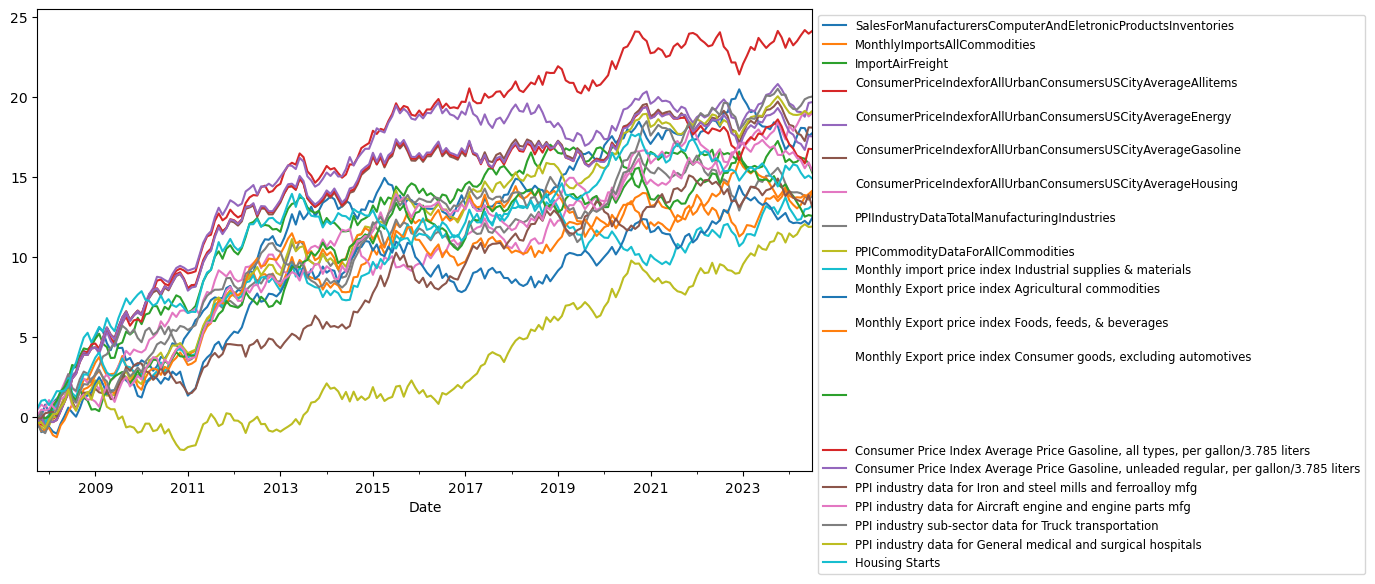

In [18]:
cumic(selected_features, ic_df)

In [19]:
ic_df[selected_features].corr()

,SalesForManufacturersComputerAndEletronicProductsInventories,MonthlyImportsAllCommodities,ImportAirFreight,ConsumerPriceIndexforAllUrbanConsumersUSCityAverageAllitems\n,ConsumerPriceIndexforAllUrbanConsumersUSCityAverageEnergy\n,ConsumerPriceIndexforAllUrbanConsumersUSCityAverageGasoline\n,ConsumerPriceIndexforAllUrbanConsumersUSCityAverageHousing\n,PPIIndustryDataTotalManufacturingIndustries\n,PPICommodityDataForAllCommodities,Monthly import price index Industrial supplies & materials,Monthly Export price index Agricultural commodities\n,"Monthly Export price index Foods, feeds, & beverages\n","Monthly Export price index Consumer goods, excluding automotives\n\n\n\n\n","Consumer Price Index Average Price Gasoline, all types, per gallon/3.785 liters","Consumer Price Index Average Price Gasoline, unleaded regular, per gallon/3.785 liters",PPI industry data for Iron and steel mills and ferroalloy mfg,PPI industry data for Aircraft engine and engine parts mfg,PPI industry sub-sector data for Truck transportation,PPI industry data for General medical and surgical hospitals,Housing Starts
SalesForManufacturersComputerAndEletronicProductsInventories,1.000000,0.097886,0.026192,0.057541,0.045942,0.010867,0.044699,0.052364,0.120911,0.075840,0.202538,0.208984,0.130004,0.011088,0.014811,-0.220186,-0.007451,0.094233,0.106576,0.048978
MonthlyImportsAllCommodities,0.097886,1.000000,0.258256,0.443449,0.411839,0.470374,-0.010264,0.626540,0.564242,0.949922,0.167662,0.158385,0.248576,0.480383,0.471610,0.216227,0.283322,0.517852,0.231815,0.317871
ImportAirFreight,0.026192,0.258256,1.000000,0.216392,0.225640,0.316492,-0.094818,0.167106,0.206168,0.316168,0.159401,0.192641,0.079060,0.312472,0.315173,0.243103,0.111221,0.284202,0.198181,0.173479
ConsumerPriceIndexforAllUrbanConsumersUSCityAverageAllitems\n,0.057541,0.443449,0.216392,1.000000,0.674080,0.714795,0.282849,0.585394,0.526534,0.383830,0.175875,0.244860,0.167529,0.724173,0.718720,0.207936,0.302990,0.435093,0.151205,0.319660
ConsumerPriceIndexforAllUrbanConsumersUSCityAverageEnergy\n,0.045942,0.411839,0.225640,0.674080,1.000000,0.890721,0.125425,0.458030,0.543240,0.369223,0.162781,0.236914,0.245125,0.874097,0.886002,0.093995,0.229657,0.443386,-0.098362,0.174403
ConsumerPriceIndexforAllUrbanConsumersUSCityAverageGasoline\n,0.010867,0.470374,0.316492,0.714795,0.890721,1.000000,0.012432,0.521452,0.497734,0.428425,0.195045,0.271198,0.252045,0.989019,0.992962,0.110789,0.306316,0.457945,-0.005566,0.238033
ConsumerPriceIndexforAllUrbanConsumersUSCityAverageHousing\n,0.044699,-0.010264,-0.094818,0.282849,0.125425,0.012432,1.000000,0.120935,0.268875,-0.057329,0.093190,0.065172,0.093999,0.022875,0.014568,0.084247,0.219762,0.042587,-0.034539,0.075068
PPIIndustryDataTotalManufacturingIndustries\n,0.052364,0.626540,0.167106,0.585394,0.458030,0.521452,0.120935,1.000000,0.737572,0.557254,0.283083,0.256842,0.370480,0.540981,0.531006,0.344890,0.324175,0.555743,0.314582,0.365594
PPICommodityDataForAllCommodities,0.120911,0.564242,0.206168,0.526534,0.543240,0.497734,0.268875,0.737572,1.000000,0.512655,0.494492,0.484049,0.370099,0.506020,0.500806,0.387574,0.322915,0.603552,0.215397,0.192139
Monthly import price index Industrial supplies & materials,0.075840,0.949922,0.316168,0.383830,0.369223,0.428425,-0.057329,0.557254,0.512655,1.000000,0.157655,0.157035,0.207458,0.435345,0.427974,0.228453,0.244547,0.478045,0.205909,0.291926


In [20]:
def hot_corr(name,ic_df):

    ax = plt.subplots(figsize=(len(name), len(name)))
    ax = sns.heatmap(ic_df[name].corr(),vmin=0.4, square=True, annot= True,cmap = 'Blues')
    plt.title('Factors_IC_CORRELATION')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

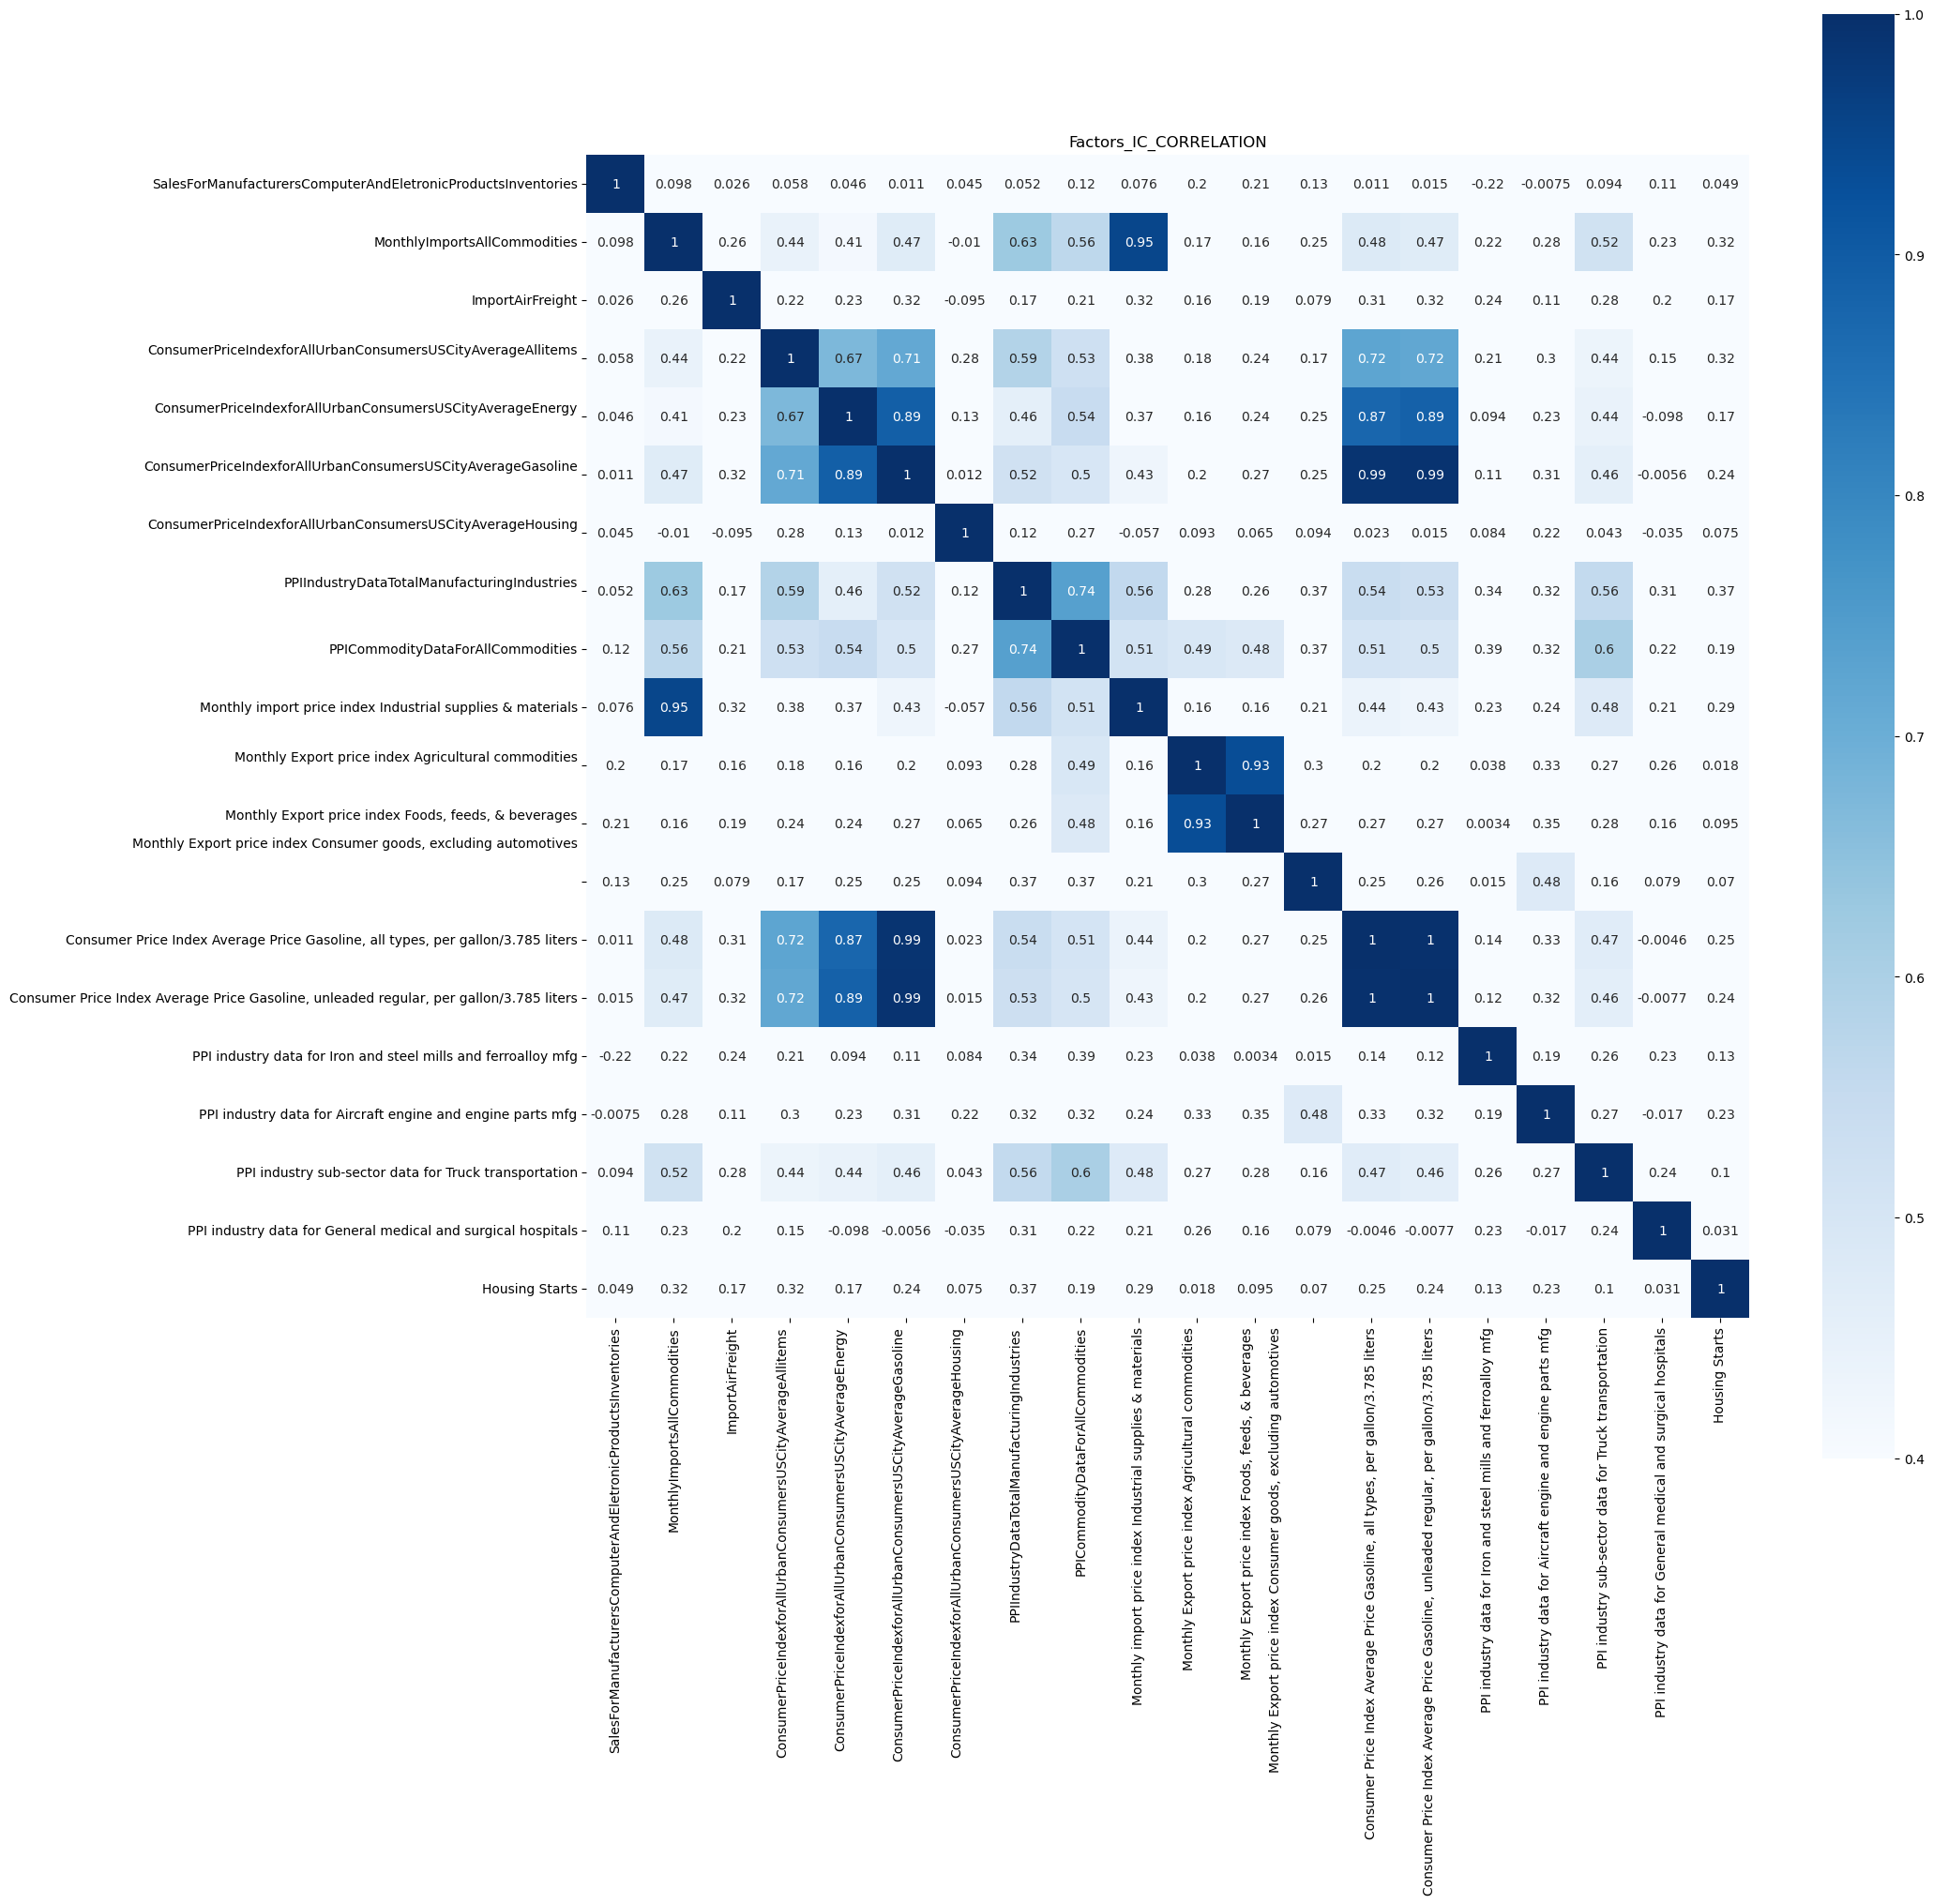

In [21]:
hot_corr(selected_features, ic_df)

In [22]:
# VIF
ic_df_pass = ic_df[selected_features]
VIF = {}
for i in ic_df_pass.columns.tolist():
    y = ic_df_pass[i]
    x = ic_df_pass.drop(i,axis = 1)
    VIF[i] = 1 / (1 - sm.OLS(y.astype(float),x.astype(float),hasconst=False, missing='drop').fit().rsquared)

VIF = pd.DataFrame([VIF]).T
VIF.columns = ['VIF']
VIF.sort_values(by = 'VIF',ascending=False)

,VIF
"Consumer Price Index Average Price Gasoline, unleaded regular, per gallon/3.785 liters",216.242679
"Consumer Price Index Average Price Gasoline, all types, per gallon/3.785 liters",141.289477
ConsumerPriceIndexforAllUrbanConsumersUSCityAverageGasoline\n,83.181083
MonthlyImportsAllCommodities,13.856368
Monthly import price index Industrial supplies & materials,11.968162
"Monthly Export price index Foods, feeds, & beverages\n",11.255252
Monthly Export price index Agricultural commodities\n,11.165734
ConsumerPriceIndexforAllUrbanConsumersUSCityAverageEnergy\n,7.386083
PPICommodityDataForAllCommodities,5.001423
PPIIndustryDataTotalManufacturingIndustries\n,3.857752


In [23]:
def corr_line(ic_df,low = 0.8,high = 1):

    factor_corr = pd.DataFrame(ic_df.dropna().corr().stack())
    factor_corr.columns = ['CORRELATION']
    factor_corr.index.names = ['factor_a','factor_b']
    factor_corr = factor_corr[(factor_corr > low) & (factor_corr < high)].dropna().drop_duplicates()

    return factor_corr

In [24]:
high_data = corr_line(ic_df[selected_features])
high_data

CORRELATION
factor_a                                           factor_b                                                       
MonthlyImportsAllCommodities                       Monthly import price index Industrial supplies ...     0.949922
ConsumerPriceIndexforAllUrbanConsumersUSCityAve... ConsumerPriceIndexforAllUrbanConsumersUSCityAve...     0.890721
                                                   Consumer Price Index Average Price Gasoline, al...     0.874097
                                                   Consumer Price Index Average Price Gasoline, un...     0.886002
ConsumerPriceIndexforAllUrbanConsumersUSCityAve... Consumer Price Index Average Price Gasoline, al...     0.989019
                                                   Consumer Price Index Average Price Gasoline, un...     0.992962
Monthly Export price index Agricultural commodi... Monthly Export price index Foods, feeds, & beve...     0.933949
Consumer Price Index Average Price Gasoline, al... Consumer Price Index Average Price Gasoline, un...     0.995801

In [25]:
orth_wait = list(set(high_data.index.get_level_values(0)) | set(high_data.index.get_level_values(1)))
orth_wait

['Monthly Export price index Agricultural commodities\n',
 'Consumer Price Index Average Price Gasoline, unleaded regular, per gallon/3.785 liters',
 'Monthly import price index Industrial supplies & materials',
 'Consumer Price Index Average Price Gasoline, all types, per gallon/3.785 liters',
 'Monthly Export price index Foods, feeds, & beverages\n',
 'ConsumerPriceIndexforAllUrbanConsumersUSCityAverageGasoline\n',
 'ConsumerPriceIndexforAllUrbanConsumersUSCityAverageEnergy\n',
 'MonthlyImportsAllCommodities']

In [26]:
corr_group = {0:['MonthlyImportsAllCommodities','Monthly import price index Industrial supplies & materials'],
              1:['Monthly Export price index Agricultural commodities\n','Monthly Export price index Foods, feeds, & beverages\n'],
              2:['Consumer Price Index Average Price Gasoline, all types, per gallon/3.785 liters','Consumer Price Index Average Price Gasoline, unleaded regular, per gallon/3.785 liters'],
              3:['ConsumerPriceIndexforAllUrbanConsumersUSCityAverageEnergy\n','ConsumerPriceIndexforAllUrbanConsumersUSCityAverageGasoline\n','Consumer Price Index Average Price Gasoline, all types, per gallon/3.785 liters','Consumer Price Index Average Price Gasoline, unleaded regular, per gallon/3.785 liters']}

In [27]:
for i in list(corr_group.keys()):
    del_factors = ic_summary.loc[corr_group[i],'IR'].sort_values(ascending = False).index.tolist()[1:]
    selected_features = [feature for feature in selected_features if feature not in del_factors]
selected_features

['SalesForManufacturersComputerAndEletronicProductsInventories',
 'MonthlyImportsAllCommodities',
 'ImportAirFreight',
 'ConsumerPriceIndexforAllUrbanConsumersUSCityAverageAllitems\n',
 'ConsumerPriceIndexforAllUrbanConsumersUSCityAverageEnergy\n',
 'ConsumerPriceIndexforAllUrbanConsumersUSCityAverageHousing\n',
 'PPIIndustryDataTotalManufacturingIndustries\n',
 'PPICommodityDataForAllCommodities',
 'Monthly Export price index Foods, feeds, & beverages\n',
 'Monthly Export price index Consumer goods, excluding automotives\n\n\n\n\n',
 'PPI industry data for Iron and steel mills and ferroalloy mfg',
 'PPI industry data for Aircraft engine and engine parts mfg',
 'PPI industry sub-sector data for Truck transportation',
 'PPI industry data for General medical and surgical hospitals',
 'Housing Starts']

In [28]:
def corr_line(ic_df,low = 0.65,high = 1):
    
    factor_corr = pd.DataFrame(ic_df.dropna().corr().stack())
    factor_corr.columns = ['CORRELATION']
    factor_corr.index.names = ['factor_a','factor_b']
    factor_corr = factor_corr[(factor_corr > low) & (factor_corr < high)].dropna().drop_duplicates()

    return factor_corr

In [29]:
middle_data = corr_line(ic_df[selected_features])
middle_data

,,CORRELATION
factor_a,factor_b,
ConsumerPriceIndexforAllUrbanConsumersUSCityAverageAllitems\n,ConsumerPriceIndexforAllUrbanConsumersUSCityAverageEnergy\n,0.674080
PPIIndustryDataTotalManufacturingIndustries\n,PPICommodityDataForAllCommodities,0.737572


(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'ConsumerPriceIndexforAllUrbanConsumersUSCityAverageEnergy\n'),
  Text(0, 1.5, 'ConsumerPriceIndexforAllUrbanConsumersUSCityAverageAllitems\n'),
  Text(0, 2.5, 'PPIIndustryDataTotalManufacturingIndustries\n'),
  Text(0, 3.5, 'PPICommodityDataForAllCommodities')])

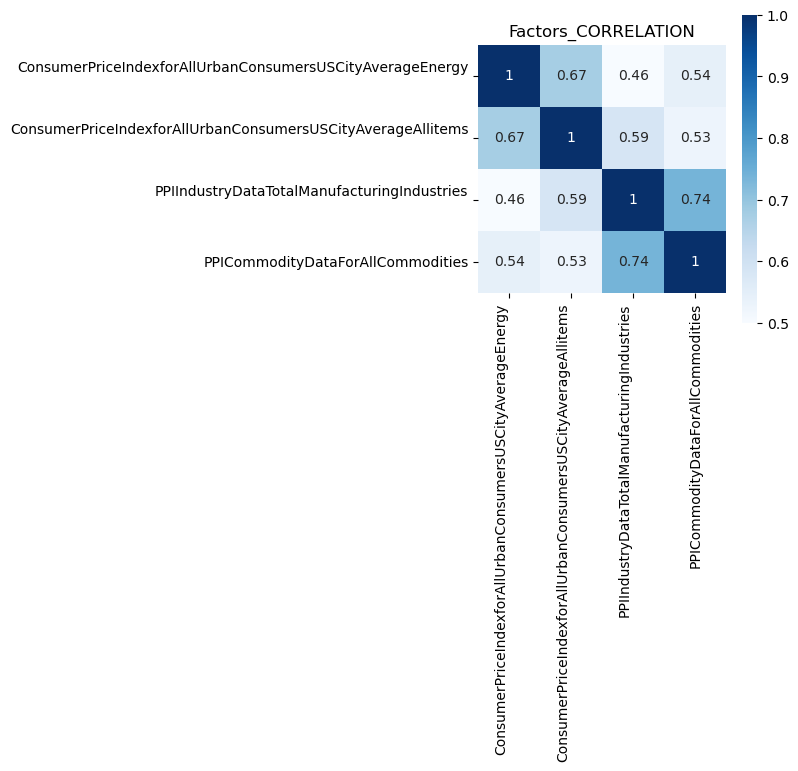

In [30]:
orth_wait = list(set(middle_data.index.get_level_values(0)) | set(middle_data.index.get_level_values(1)))
ax = plt.subplots(figsize=(len(orth_wait), len(orth_wait)))
ax = sns.heatmap(ic_df[orth_wait].corr(),vmin=0.5, square=True, annot= True,cmap = 'Blues')
plt.title('Factors_CORRELATION')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

In [31]:
selected_features

['SalesForManufacturersComputerAndEletronicProductsInventories',
 'MonthlyImportsAllCommodities',
 'ImportAirFreight',
 'ConsumerPriceIndexforAllUrbanConsumersUSCityAverageAllitems\n',
 'ConsumerPriceIndexforAllUrbanConsumersUSCityAverageEnergy\n',
 'ConsumerPriceIndexforAllUrbanConsumersUSCityAverageHousing\n',
 'PPIIndustryDataTotalManufacturingIndustries\n',
 'PPICommodityDataForAllCommodities',
 'Monthly Export price index Foods, feeds, & beverages\n',
 'Monthly Export price index Consumer goods, excluding automotives\n\n\n\n\n',
 'PPI industry data for Iron and steel mills and ferroalloy mfg',
 'PPI industry data for Aircraft engine and engine parts mfg',
 'PPI industry sub-sector data for Truck transportation',
 'PPI industry data for General medical and surgical hospitals',
 'Housing Starts']

In [32]:
base_function = ['add', 'sub', 'mul', 'div','abs','neg']

window = 10

def _delta(data):
    value = np.diff(data.flatten())
    value = np.append(0, value)

    return value

def _sma(data):
    window=36
    value = np.array(pd.Series(data.flatten()).rolling(window).mean().tolist())
    value = np.nan_to_num(value)
    
    return value

def _stddev(data):
    window=36
    value = np.array(pd.Series(data.flatten()).rolling(window).std().tolist())
    value = np.nan_to_num(value)
    return value

stddev = make_function(function=_stddev, name='stddev', arity=1)
delta = make_function(function=_delta, name='delta', arity=1)
sma = make_function(function=_sma, name='sma', arity=1)

user_function = [stddev,delta,sma]

function_set = base_function + user_function

In [36]:
rolling_exposure

BusinessApplications ConstructionSpending  \
Tickers Date                                                   
XLB     2007-11-30             0.000002            -0.000007   
        2007-12-31            -0.000001            -0.000001   
        2008-01-31            -0.000005             0.000003   
        2008-02-29            -0.000005             0.000003   
        2008-03-31            -0.000001             0.000003   
...                                 ...                  ...   
XLY     2024-03-31            -0.000004            -0.000003   
        2024-04-30            -0.000003            -0.000004   
        2024-05-31            -0.000003            -0.000004   
        2024-06-30            -0.000003            -0.000004   
        2024-07-31            -0.000004            -0.000002   

                   DurableGoodsNewOrders InternationalTrade_Exports  \
Tickers Date                                                          
XLB     2007-11-30             -0.000024                   0.000088   
        2007-12-31             -0.000011                   0.000064   
        2008-01-31             -0.000006                   0.000045   
        2008-02-29             -0.000006                   0.000046   
        2008-03-31              -0.00001                   0.000043   
...                                  ...                        ...   
XLY     2024-03-31              -0.00001                   0.000009   
        2024-04-30             -0.000013                   0.000006   
        2024-05-31             -0.000009                   0.000006   
        2024-06-30             -0.000005                   0.000007   
        2024-07-31             -0.000001                    0.00001   

                   InternationalTrade_Imports ManuInventories ManuNewOrders  \
Tickers Date                                                                  
XLB     2007-11-30                   0.000056        0.000016      0.000021   
        2007-12-31                   0.000013       -0.000001      0.000003   
        2008-01-31                   0.000012        0.000019      0.000001   
        2008-02-29                   0.000012        0.000019      0.000001   
        2008-03-31                  -0.000003       -0.000011     -0.000004   
...                                       ...             ...           ...   
XLY     2024-03-31                  -0.000002       -0.000004      0.000011   
        2024-04-30                  -0.000002       -0.000013      0.000008   
        2024-05-31                   0.000001        -0.00001      0.000004   
        2024-06-30                   0.000001       -0.000009      0.000002   
        2024-07-31                   0.000001        0.000001     -0.000001   

                   NewHomesForSale NewHomesSold ResConstPermits  ...  \
Tickers Date                                                     ...   
XLB     2007-11-30       -0.000043     0.000002        0.000182  ...   
        2007-12-31       -0.000045     0.000068         0.00018  ...   
        2008-01-31       -0.000031     0.000043       -0.000103  ...   
        2008-02-29       -0.000032     0.000043       -0.000096  ...   
        2008-03-31       -0.000009     0.000147       -0.000055  ...   
...                            ...          ...             ...  ...   
XLY     2024-03-31       -0.000023    -0.000111         0.00002  ...   
        2024-04-30        -0.00002    -0.000112        0.000029  ...   
        2024-05-31       -0.000019    -0.000114        0.000039  ...   
        2024-06-30       -0.000021    -0.000128        0.000053  ...   
        2024-07-31       -0.000012    -0.000055        0.000065  ...   

                     US_10yr       CPI Housing Starts Monetary Base        M2  \
Tickers Date                                                                    
XLB     2007-11-30 -0.000003  0.000002       0.000009     -0.000029  0.000217   
        2007-12-31 -0.000003  0.000005       -0.00014 

In [41]:
gp_data_train = df.copy()
gp_factor_train = rolling_exposure[selected_features]
base_Factor = gp_factor_train.columns.tolist()
gp_factor_train.head()

SalesForManufacturersComputerAndEletronicProductsInventories  \
Tickers Date                                                                      
XLB     2007-11-30                                           0.000126             
        2007-12-31                                            0.00023             
        2008-01-31                                           0.000162             
        2008-02-29                                           0.000164             
        2008-03-31                                           0.000119             

                   MonthlyImportsAllCommodities ImportAirFreight  \
Tickers Date                                                       
XLB     2007-11-30                    -0.000007         0.000001   
        2007-12-31                    -0.000006         0.000001   
        2008-01-31                    -0.000004        -0.000004   
        2008-02-29                    -0.000004        -0.000004   
        2008-03-31                    -0.000001        -0.000002   

                   ConsumerPriceIndexforAllUrbanConsumersUSCityAverageAllitems\n  \
Tickers Date                                                                       
XLB     2007-11-30                                          -0.000001              
        2007-12-31                                           0.000001              
        2008-01-31                                          -0.000002              
        2008-02-29                                          -0.000002              
        2008-03-31                                               -0.0              

                   ConsumerPriceIndexforAllUrbanConsumersUSCityAverageEnergy\n  \
Tickers Date                                                                     
XLB     2007-11-30                                          -0.000025            
        2007-12-31                                          -0.000008            
        2008-01-31                                          -0.000025            
        2008-02-29                                          -0.000025            
        2008-03-31                                          -0.000005            

                   ConsumerPriceIndexforAllUrbanConsumersUSCityAverageHousing\n  \
Tickers Date                                                                      
XLB     2007-11-30                                          -0.000003             
        2007-12-31                                          -0.000002             
        2008-01-31                                          -0.000002             
        2008-02-29                                          -0.000002             
        2008-03-31                                          -0.000001             

                   PPIIndustryDataTotalManufacturingIndustries\n  \
Tickers Date                                                       
XLB     2007-11-30                                     -0.000004   
        2007-12-31                                     -0.000002   
        2008-01-31                                     -0.000004   
        2008-02-29                                     -0.000004   
        2008-03-31                                           0.0   

                   PPICommodityDataForAllCommodities  \
Tickers Date                                           
XLB     2007-11-30                         -0.000001   
        2007-12-31                          0.000004   
        2008-01-31                         -0.000004   
        2008-02-29                         -0.000004   
        2008-03-31                          0.000001   

                   Monthly Export price index Foods, feeds, & beverages\n  \
Tickers Date                                                                
XLB     2007-11-30                                           0.000018       
        2007-12-31                                           0.000024       
        2008-01-31                  

In [42]:
gp_data_train

Price  BusinessApplications  ConstructionSpending  \
Tickers Date                                                                
XLB     2004-12-31   19.24945                193328               1037480   
        2005-01-31   18.66025                201725               1046082   
        2005-02-28   20.13002                204234               1066848   
        2005-03-31   19.59500                201630               1071745   
        2005-04-30   18.19814                204096               1081012   
...                       ...                   ...                   ...   
XLY     2024-04-30  174.88220                430762               2163179   
        2024-05-31  175.23070                423211               2168211   
        2024-06-30  182.02440                430692               2168990   
        2024-07-31  187.10390                421534               2162683   
        2024-08-31  186.73470                431928               2162683   

                    DurableGoodsNewOrders  InternationalTrade_Exports  \
Tickers Date                                                            
XLB     2004-12-31                 193578                      102781   
        2005-01-31                 194875                      103206   
        2005-02-28                 196475                      104010   
        2005-03-31                 186608                      105098   
        2005-04-30                 194847                      107268   
...                                   ...                         ...   
XLY     2024-04-30                 282737                      262314   
        2024-05-31                 282987                      260790   
        2024-06-30                 263541                      265266   
        2024-07-31                 289587                      266603   
        2024-08-31                 289720                      266603   

                    InternationalTrade_Imports  ManuInventories  \
Tickers Date                                                      
XLB     2004-12-31                      157699           441222   
        2005-01-31                      159395           446240   
        2005-02-28                      162104           451361   
        2005-03-31                      158231           455394   
        2005-04-30                      164580           456990   
...                                        ...              ...   
XLY     2024-04-30                      337217           858304   
        2024-05-31                      336096           859416   
        2024-06-30                      338282           858851   
        2024-07-31                      345394           859422   
        2024-08-31                      345394           859422   

                    ManuNewOrders  NewHomesForSale  NewHomesSold  ...  \
Tickers Date                                                      ...   
XLB     2004-12-31         373419              422          1242  ...   
        2005-01-31         378937              441          1203  ...   
        2005-02-28         381880              446          1319  ...   
        2005-03-31         374642              445          1328  ...   
        2005-04-30         385450              445          1260  ...   
...                           ...              ...           ...  ...   
XLY     2024-04-30         586114              464           736  ...   
        2024-05-31         583300              468           672  ...   
        2024-06-30         563972              468           681  ...   
        2024-07-31         592140              459           751  ...   
        2024-08-31         592140              467           716  ...   

                        CPI  Housing Starts  Monetary Base       M2  \
Tickers Date                                                          
XLB     2004-12-31  191.700            1782          770.5   6399.8   
        2005-01-31  191.700          

In [43]:
stock_list = gp_data_train.index.get_level_values(0).tolist()
stock_list
del_index = []
for i in range(1,len(stock_list)):
    if stock_list[i - 1] != stock_list[i]:
        del_index.append(i)

In [45]:
def _my_metric_group(y, y_pred, w):
    x1 = pd.Series(y.flatten())
    for i in del_index:
        try:
            y_pred[i:i+window*5] = np.nan           
        except:
            break
    
    x2 = pd.Series(y_pred.flatten())
  
    df = pd.concat([x1.to_frame('y'),
                    x2.to_frame('y_pred')],axis=1).dropna()

   
    df.sort_values(by = 'y_pred',ascending = True,inplace = True)
    
    gap = [int(i) for i in list(np.linspace(start = 0, stop = len(df), num = 11))]
    y_1 = df["y"][0:gap[1]].mean()
    y_2 = df["y"][gap[1]:gap[2]].mean()
    y_3 = df["y"][gap[2]:gap[3]].mean()
    y_4 = df["y"][gap[3]:gap[4]].mean()
    y_5 = df["y"][gap[4]:gap[5]].mean()
    y_6 = df["y"][gap[5]:gap[6]].mean()
    y_7 = df["y"][gap[6]:gap[7]].mean()
    y_8 = df["y"][gap[7]:gap[8]].mean()
    y_9 = df["y"][gap[8]:gap[9]].mean()
    y_10 = df["y"][gap[9]:].mean()
   
    value = (np.corrcoef(np.array([y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10]).argsort(),
                         (np.arange(1,11)))[0,1])
    
    return value

my_metric_group = make_fitness(function=_my_metric_group, greater_is_better=True)

In [46]:
gp_factor_train[base_Factor].index

MultiIndex([('XLB', '2007-11-30'),
            ('XLB', '2007-12-31'),
            ('XLB', '2008-01-31'),
            ('XLB', '2008-02-29'),
            ('XLB', '2008-03-31'),
            ('XLB', '2008-04-30'),
            ('XLB', '2008-05-31'),
            ('XLB', '2008-06-30'),
            ('XLB', '2008-07-31'),
            ('XLB', '2008-08-31'),
            ...
            ('XLY', '2023-10-31'),
            ('XLY', '2023-11-30'),
            ('XLY', '2023-12-31'),
            ('XLY', '2024-01-31'),
            ('XLY', '2024-02-29'),
            ('XLY', '2024-03-31'),
            ('XLY', '2024-04-30'),
            ('XLY', '2024-05-31'),
            ('XLY', '2024-06-30'),
            ('XLY', '2024-07-31')],
           names=['Tickers', 'Date'], length=1927)

In [47]:
X_train = np.nan_to_num(gp_factor_train[base_Factor].values)
y_train = np.nan_to_num(df.loc[gp_factor_train[base_Factor].index]['Return'])

metric_type = 'my_metric_group'
version = 'v3'

generations = 3
population_size = 10000
random_state = 0

est_gp = SymbolicTransformer(feature_names = base_Factor,                     
                            function_set = function_set,                     
                            stopping_criteria = 0.03,                         
                            metric = my_metric_group,                         
                            generations = generations,                        
                            population_size = population_size,                
                            tournament_size = 50,                             
                            init_depth = (2,2),                               
                            random_state = random_state,                      
                            n_components = 20,                                
                            const_range = (-1,1),                             
                            n_jobs = -1                                    
                         )


est_gp.fit(X_train, y_train)

best_programs = est_gp._best_programs
best_programs_dict = {}

for p in best_programs:
    factor_name = 'Macro_Factors' + str(best_programs.index(p) + 1)
    best_programs_dict[factor_name] = {'fitness':p.fitness_, 'expression':str(p), 'depth':p.depth_, 'length':p.length_}

best_programs_dict = pd.DataFrame(best_programs_dict).T
best_programs_dict = best_programs_dict[best_programs_dict.fitness.abs() >= 0.2]
best_programs_dict = best_programs_dict.sort_values(by= 'fitness',ascending=False)
best_programs_dict

,fitness,expression,depth,length
Macro_Factors1,0.959636,mul(delta(PPI industry data for Aircraft engin...,2,4
Macro_Factors2,0.948515,add(PPI industry data for Iron and steel mills...,1,3
Macro_Factors3,0.945515,"mul(neg(-0.254), add(PPIIndustryDataTotalManuf...",2,6
Macro_Factors4,0.932394,"add(mul(0.031, Monthly Export price index Food...",2,7
Macro_Factors6,0.921273,sub(sub(PPI industry data for Iron and steel m...,2,6
Macro_Factors5,0.920273,"add(add(0.041, ConsumerPriceIndexforAllUrbanCo...",2,7
Macro_Factors7,0.912152,stddev(sma(PPI industry data for Aircraft engi...,2,3
Macro_Factors8,0.912152,sub(ConsumerPriceIndexforAllUrbanConsumersUSCi...,1,3
Macro_Factors9,0.90003,delta(sma(ConsumerPriceIndexforAllUrbanConsume...,2,3
Macro_Factors10,0.90003,delta(sma(ConsumerPriceIndexforAllUrbanConsume...,2,3


In [48]:
import graphviz
def alpha_factor_graph(num):

    factor = best_programs[num-1]
    print(factor)
    print('fitness: {0}, depth: {1}, length: {2}'.format(factor.fitness_, factor.depth_, factor.length_))

    dot_data = factor.export_graphviz()
    graph = graphviz.Source(dot_data)
    graph.render('images/alpha_factor_graph', format='png', cleanup=True)
    
    return graph

add(add(0.041, ConsumerPriceIndexforAllUrbanConsumersUSCityAverageEnergy
), sub(ConsumerPriceIndexforAllUrbanConsumersUSCityAverageEnergy
, Monthly Export price index Consumer goods, excluding automotives




))
fitness: 0.9202727272727272, depth: 2, length: 7


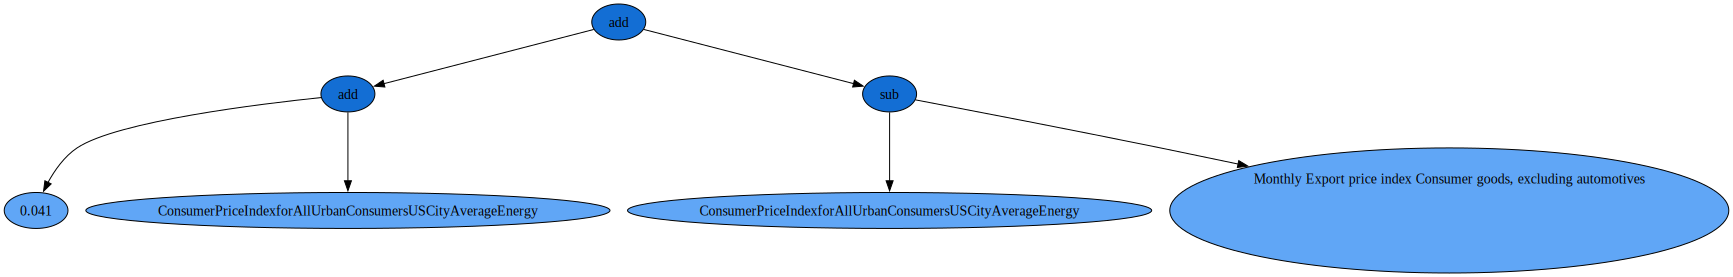

In [49]:
alpha_factor_graph(5)

In [50]:
def macro_factor_5(df):
    value1 = df['ConsumerPriceIndexforAllUrbanConsumersUSCityAverageAllitems\n'].rolling(36).mean()
    value = value1.pct_change()
    
    return value.unstack('Tickers')

In [51]:
macro_5 = macro_factor_5(rolling_exposure)

In [52]:
def exposure_return_IC(exposures, returns, index_item, name=''):
    result = exposures.corrwith(returns, axis=1, method='spearman').dropna(how='all')
    t_stat, _ = stats.ttest_1samp(result, 0)
    
    report = {'name': name,
    'IC mean':round(result.mean(),4),
    'IC std':round(result.std(),4),
    'IR':round(result.mean()/result.std(),4),
    'IC>0':round(len(result[result>0].dropna())/len(result),4),
    'ABS_IC>2%':round(len(result[abs(result) > 0.02].dropna())/len(result),4),
    't_stat':round(t_stat,4),
    }

    report = pd.DataFrame([report])
    
    return result,report
                                                                        
                           

In [53]:
def Rank_IC(exposures, returns, name=''):
    result = exposures.corrwith(returns, axis=1, method='spearman').dropna(how='all')
    t_stat, _ = stats.ttest_1samp(result, 0)

    report = {'name': name,
    'IC mean':round(result.mean(),4),
    'IC std':round(result.std(),4),
    'IR':round(result.mean()/result.std(),4),
    'IC>0':round(len(result[result>0].dropna())/len(result),4),
    'ABS_IC>2%':round(len(result[abs(result) > 0.02].dropna())/len(result),4),
    't_stat':round(t_stat,4),
    }

    report = pd.DataFrame([report])
    print(report)
    return result,report

In [54]:
m5_ic, m5_df = Rank_IC(macro_5, returns, 'macro_5')

      name  IC mean  IC std      IR    IC>0  ABS_IC>2%  t_stat
0  macro_5  -0.0229  0.3671 -0.0623  0.4604     0.9356 -0.8851


<Axes: xlabel='Date'>

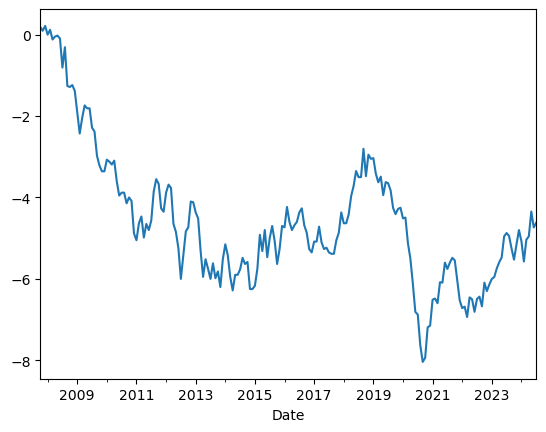

In [55]:
m5_ic.sort_index().cumsum().plot()

mul(ConsumerPriceIndexforAllUrbanConsumersUSCityAverageEnergy
, stddev(PPIIndustryDataTotalManufacturingIndustries
))
fitness: 0.8869090909090909, depth: 2, length: 4


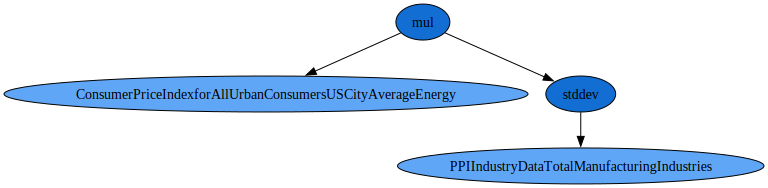

In [56]:
alpha_factor_graph(16)

In [57]:
def macro_factor_16(df):
    value1 = - df['ConsumerPriceIndexforAllUrbanConsumersUSCityAverageAllitems\n']
    value = df['PPI industry data for Aircraft engine and engine parts mfg'] - value1
    
    return value.unstack('Tickers')

       name  IC mean  IC std      IR    IC>0  ABS_IC>2%  t_stat
0  macro_16   0.0975  0.4148  0.2351  0.5644     0.9703  3.3414


<Axes: xlabel='Date'>

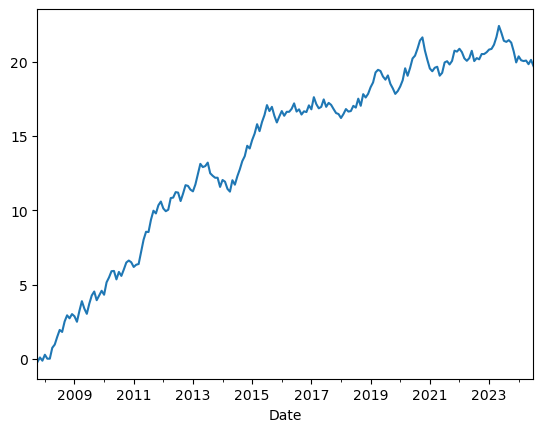

In [58]:
macro_16 = macro_factor_16(rolling_exposure)
m16_ic, m16_df = Rank_IC(macro_16, returns, 'macro_16')
m16_ic.sort_index().cumsum().plot()